<a href="https://colab.research.google.com/github/RonBartov/Introduction_to_Optimization/blob/main/chebyshev_approx_and_duality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chebyshev Approximation and Duality**

In [19]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

## **The Goal**

The goal is to minimize the maximum absolute error for the linear model $ y_i = \mathbf{a}^T \mathbf{x}_i - b + \epsilon_i $:
$$ p^* = \min_{\mathbf{a} \in \mathbb{R}^n, b \in \mathbb{R}} \max_{i=0,\ldots,k-1} |y_i - (\mathbf{a}^T \mathbf{x}_i - b)| $$

## **Transformation to LP**
We can transform the given problem into a linear optimization problem by introducing an auxiliary variable $ t $:

$$ \min_{t, \mathbf{a}, b} t $$
Subject to:
$$ t \geq y_i - \mathbf{a}^T \mathbf{x}_i + b, i \in 0,2,...k-1 $$
$$ t \geq -y_i + \mathbf{a}^T \mathbf{x}_i - b, i \in 0,2,...k-1 $$
$$ t \geq 0 $$
with total of $2k+1$ constrains


<br>

## **Presenting the Problem in a Matrix Form**
${\circ}$ We will mark the decision variables vector to be  $ z = [t , \mathbf{a^T} , b]^T \in \mathbb{R}^{n+2}$

Note that $z$ is of size $(n+2)\times1$

${\circ}$ The inequality constraint matrix will have the size of $(2k+1)\times(n+2)$ and the following values:

$$
A[i,:] =
\begin{cases}
[-1 \ , \ -\mathbf{x}_i^T \ , \ 1], & \text{for} \ i = 0,1,\ldots,k-1 \\
[-1 \ , \ -\mathbf{x}_i^T \ , \ -1], & \text{for} \ i = k,k+1,\ldots,2k-1 \\
[-1 \ , \ \mathbf{0}_{1\times{(n+1)}}], & \text{for} \ i = 2k \\
\end{cases}
$$

${\circ}$ The inequality constrains vector $b_{ub}$ will have the following values:

$$
b_{ub} =
\begin{cases}
[-y_0,-y_1,...,-y_{k-1}], & \text{for} \ i = 0,1,\ldots,k-1 \\
[y_0,y_1,...,y_{k-1}], & \text{for} \ i = k,k+1,\ldots,2k-1 \\
0, & \text{for} \ i = 2k \\
\end{cases}
$$

${\circ}$ The coefficients of the linear objective function to be minimized will be:
$$ c = [1,\mathbf{0}_{1\times{(n+1)}}] $$

${\circ}$ Now, the LP problem can be represented with the following form:

$$ \min_{z\in\mathbb{R}^{n+2}} \mathbf{c^T}\mathbf{z} $$

$$\text{such that:} $$

$$ A\mathbf{z}\leq \mathbf{b_{ub}}$$

## **Simulation**
We will perform a simulation for solving the above problem using scipy linear programming function.
The solution will include the following steps:

### **1. Generation of Random Synthetic Data**
We will generate random synthetic data based on some ID number.

$\circ$ We will start with initializing the true parameters $a_{true}$ and $b_{true}$ while taking the first 8 digits to be the vector $a_{true}$ and the last digit to be the constant $b_{true}$.

For example, for the ID number $123456789$, the true parameters will be the following:
$$ \mathbf{a_{true}} = [1, 2, 3, 4, 5, 6, 7, 8]^T $$
$$ b_{true} = 9 $$

$\circ$ We will generate $k$ random samples {$y_i$} while using $k$ random vector samples $\mathbf{x_i}$ uniformly distributed over $[0,1)$ and adding white gauusian noise samples $\epsilon_i$.

$ \text{for each i, }y_i = \mathbf{a_{true}}^T \mathbf{x}_i - b_{true} + \epsilon_i $

### **2. Generate the Constrain Matrix and Vector**
We will generate $A$ and $b_{ub}$ according to the previous explanation.

### **3. Performing Monte Carlo Simulation for different variance (or std) values and Calculating the Error**
We will perform monte carlo simulation for different values of the varianc of the white gaussian noise.

In each simulation, we will:
1. Generate new random white noise samples
2. Calculate the decision variables that minimizes the objective function with scipy.linprog function ($\mathbf{z_{min}} = [t_{min} , \mathbf{a_{min}^T} , b_{min}]^T$)
3. Calculate the error $|[\mathbf{a_{min}^T} , b_{min}]^T - [\mathbf{a_{true}^T} , b_{true}]^T|$


### **4. Presenting the Results Visually**
Presenting graphs with the avarage results for each variance value

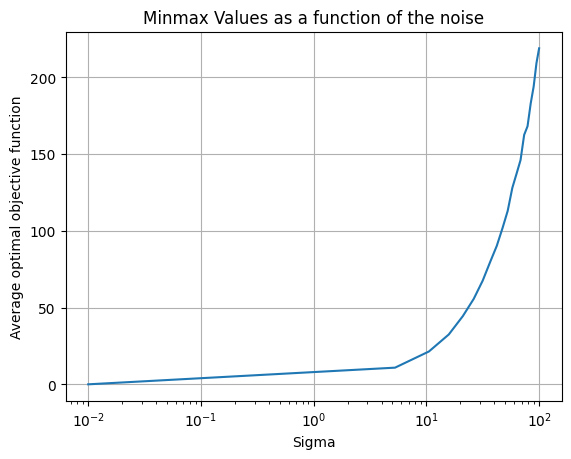

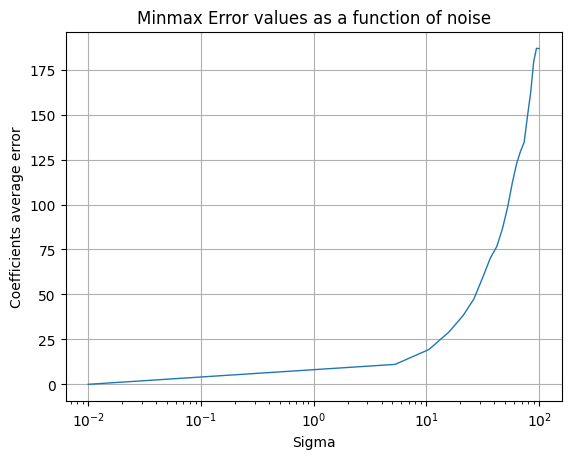

In [21]:
# Initialization
a_true = np.array([1, 2, 3, 4, 5, 6, 7, 8])
b_true = 9
len_a_t = len(a_true)
k = 100
num_of_diff_sigmas = 20
sigma_vector = np.linspace(0.01, 100, num_of_diff_sigmas) # different std values for randomness
num_simulations = 100 # number of monte carlo simulations

# Placeholders for errors for each simulation
len_sigma = len(sigma_vector)
errors_lp = np.zeros((len_sigma, num_simulations))
p_star_lp = np.zeros((len_sigma, num_simulations))

# Generate X matrix: each column represent x vector sample (total k samples)
x = np.random.rand(len_a_t, k)

# Main loop for different sigma values
for r, sigma in enumerate(sigma_vector):
    for s in range(num_simulations):
        epsilon = np.random.normal(0, sigma, k)
        y = a_true @ x - b_true + epsilon

        # Linear programming setup
        c = np.hstack(([1], np.zeros(len_a_t + 1)))
        A = np.zeros((2 * k + 1, len_a_t + 2))
        A[:, 0] = -1
        A[:k, -1] = 1
        A[k:2*k, -1] = -1

        for i in range(k):
            A[i, 1:-1] = -x[:, i]
            A[k + i, 1:-1] = x[:, i]
        b_ub = np.hstack((-y, y, 0))

        # Solve using LP
        opt_lp = linprog(c, A_ub=A, b_ub=b_ub, method='highs')
        opt_lp_a_b = opt_lp.x[1:] # 0 element is t, the rest are a and b
        true_a_b = np.append(a_true,b_true)
        errors_lp[r, s] = np.linalg.norm(opt_lp_a_b - true_a_b)
        p_star_lp[r, s] = opt_lp.fun

# Compute means over all simulations
mean_p_star_lp = np.mean(p_star_lp, axis=1)
mean_errors_lp = np.mean(errors_lp, axis=1)

# Plot results
plt.figure()
plt.semilogx(sigma_vector, mean_p_star_lp, linewidth=1.5)
plt.grid(True)
plt.title('Minmax Values as a function of the noise')
plt.xlabel('Sigma')
plt.ylabel('Average optimal objective function')

plt.figure()
plt.semilogx(sigma_vector, mean_errors_lp, label='minmax error', linewidth=1)
plt.grid(True)
plt.title('Minmax Error values as a function of noise')
plt.xlabel('Sigma')
plt.ylabel('Coefficients average error')

plt.show()